In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
assert(nltk.download('wordnet'))  # Make sure we have the wordnet data.
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [ ]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/MBD/analisis_de_datos_no_estructurados/practica_texto')
print(os.listdir("data/"))
# import warnings
# warnings.filterwarnings('ignore')

['Corona_NLP_test.csv', 'Corona_NLP_train.csv']


In [ ]:
import warnings
warnings.filterwarnings('ignore')

corona_data_train = pd.read_csv('data/Corona_NLP_train.csv', encoding='cp437', on_bad_lines = 'skip')
corona_data_train = corona_data_train.loc[(corona_data_train['Sentiment'] == "Positive") | (corona_data_train['Sentiment'] == "Negative")]

corona_data_test = pd.read_csv('data/Corona_NLP_test.csv', encoding='cp437', on_bad_lines = 'skip')
corona_data_test = corona_data_test.loc[(corona_data_test['Sentiment'] == "Positive") | (corona_data_test['Sentiment'] == "Negative")]

print("TRAIN", corona_data_train.shape)
print("TEST", corona_data_test.shape)

TRAIN (21339, 6)
TEST (1988, 6)


In [ ]:
corona_data_train.head()

UserName  ScreenName                   Location     TweetAt  \
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                        NaN  16-03-2020   
5      3804       48756  ├£T: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   

                                       OriginalTweet Sentiment  
1  advice Talk to your neighbours family to excha...  Positive  
2  Coronavirus Australia: Woolworths to give elde...  Positive  
3  My food stock is not the only one which is emp...  Positive  
5  As news of the region┬Æs first confirmed COVID...  Positive  
6  Cashier at grocery store was sharing his insig...  Positive

In [ ]:
corona_data_train.iloc[1000,:]['OriginalTweet']

'Went out to our local Edeka supermarket for some essentials. Was very happy to see them limiting the number of people in the store, sanitising everyone┬Æs hands on entry and allowing the elderly to skip the queue. Calm queue with no panic ?? #COVID2019 https://t.co/iT8LUOVwYD'

In [ ]:
#sentiment count
corona_data_train['Sentiment'].value_counts()

Positive    11422
Negative     9917
Name: Sentiment, dtype: int64

## Text Normalization

In [ ]:
nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Removing html strips and noise text

In [ ]:
corona_data_train['OriginalTweet']=corona_data_train['OriginalTweet'].apply(denoise_text)
corona_data_test['OriginalTweet']=corona_data_test['OriginalTweet'].apply(denoise_text)

print("TRAIN EX:", corona_data_train.iloc[1000,:]['OriginalTweet'])
print("TEST EX:", corona_data_test.iloc[77,:]['OriginalTweet'])

TRAIN EX: Went out to our local Edeka supermarket for some essentials. Was very happy to see them limiting the number of people in the store, sanitising everyone┬Æs hands on entry and allowing the elderly to skip the queue. Calm queue with no panic ?? #COVID2019 https://t.co/iT8LUOVwYD
TEST EX: Does everyone really need to stock up on toilet paper and paper towel? Two weeks of food I can understand, but you don't need a year worth of toilet paper and paper towel. It's not like the world is ending. #coronavirus https://t.co/EeelptfqDh


In [ ]:
corona_data_train['OriginalTweet']=corona_data_train['OriginalTweet'].apply(remove_special_characters)
corona_data_test['OriginalTweet']=corona_data_test['OriginalTweet'].apply(remove_special_characters)

print("TRAIN EX:", corona_data_train.iloc[1000,:]['OriginalTweet'])
print("TEST EX:", corona_data_test.iloc[77,:]['OriginalTweet'])

TRAIN EX: Went out to our local Edeka supermarket for some essentials Was very happy to see them limiting the number of people in the store sanitising everyones hands on entry and allowing the elderly to skip the queue Calm queue with no panic  COVID2019 httpstcoiT8LUOVwYD
TEST EX: Does everyone really need to stock up on toilet paper and paper towel Two weeks of food I can understand but you dont need a year worth of toilet paper and paper towel Its not like the world is ending coronavirus httpstcoEeelptfqDh


### Text stemming

In [ ]:
corona_data_train['OriginalTweet']=corona_data_train['OriginalTweet'].apply(simple_stemmer)
corona_data_train['OriginalTweet']=corona_data_train['OriginalTweet'].apply(simple_stemmer)

print("TRAIN EX:", corona_data_train.iloc[1000,:]['OriginalTweet'])
print("TEST EX:", corona_data_test.iloc[77,:]['OriginalTweet'])

TRAIN EX: went out to our local edeka supermarket for some essenti wa veri happi to see them limit the number of peopl in the store saniti everyon hand on entri and allow the elderli to skip the queue calm queue with no panic covid2019 httpstcoit8luovwyd
TEST EX: Does everyone really need to stock up on toilet paper and paper towel Two weeks of food I can understand but you dont need a year worth of toilet paper and paper towel Its not like the world is ending coronavirus httpstcoEeelptfqDh


## Removing stop words

In [ ]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

{'about', 'in', 'had', 'him', 'my', 'needn', "she's", 'd', 'ours', 'wouldn', 'didn', 'will', 'shouldn', 'm', "shouldn't", 'itself', 'has', 'do', 't', "you'll", 'over', 'was', "doesn't", 'hasn', 'ourselves', 'there', 'more', 'can', 'y', 've', 'on', 'other', "you're", 'but', 'ma', 're', 'any', 'yourself', 'because', 'too', 'between', 'of', "mightn't", 'after', 'the', "isn't", 'her', "needn't", 'yours', 'only', 'whom', 'is', 'while', 'an', "don't", 'are', 'been', 'than', 'myself', 'to', 'ain', 'such', 'theirs', 'or', 'and', 'when', 'most', "didn't", 'should', "wasn't", "won't", 'into', "mustn't", "should've", 'very', 'mightn', 'where', 'me', 'nor', "aren't", 'same', 'by', 'shan', 'don', 'for', 'further', 'they', 'against', 'them', 'won', 'during', 'a', 'under', 'hadn', 'few', 'so', 'up', 'wasn', 'i', 'your', 'off', 'not', 'aren', "wouldn't", 'herself', "weren't", 'some', 'that', "haven't", 'isn', 'who', 'it', 'through', 'their', "hadn't", 'doing', "hasn't", 'mustn', 'he', 'his', 'own', 's

In [ ]:
corona_data_train['OriginalTweet']=corona_data_train['OriginalTweet'].apply(remove_stopwords)
corona_data_test['OriginalTweet']=corona_data_test['OriginalTweet'].apply(remove_stopwords)

In [ ]:
norm_train_tweets=corona_data_train.OriginalTweet
norm_test_tweets=corona_data_test.OriginalTweet

In [ ]:
print("TRAIN", len(norm_train_tweets))
print("TEST", len(norm_test_tweets))

TRAIN 21339
TEST 1988


## Bags of words **model**

In [ ]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_tweets=cv.fit_transform(norm_train_tweets)
#transformed test reviews
cv_test_tweets=cv.transform(norm_test_tweets)

print('BOW_cv_train:',cv_train_tweets.shape)
print('BOW_cv_test:',cv_test_tweets.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (21339, 550935)
BOW_cv_test: (1988, 550935)


## Term Frequency-Inverse Document Frequency model (TFIDF)

In [ ]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_tweets=tv.fit_transform(norm_train_tweets)
#transformed test reviews
tv_test_tweets=tv.transform(norm_test_tweets)
print('Tfidf_train:',tv_train_tweets.shape)
print('Tfidf_test:',tv_test_tweets.shape)

Tfidf_train: (21339, 550935)
Tfidf_test: (1988, 550935)


## Labeling the sentiment

In [ ]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data_train=lb.fit_transform(corona_data_train['Sentiment'])
sentiment_data_test=lb.fit_transform(corona_data_test['Sentiment'])
print("TRAIN", sentiment_data_train.shape)
print("TRAIN", sentiment_data_test.shape)

TRAIN (21339, 1)
TRAIN (1988, 1)


In [ ]:
# Son 5 categorias de sentimientos
sentiment_data_train

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
corona_data_train['Sentiment']

1        Positive
2        Positive
3        Positive
5        Positive
6        Positive
           ...   
41147    Negative
41149    Negative
41150    Positive
41154    Positive
41156    Negative
Name: Sentiment, Length: 21339, dtype: object

## Modeling

### Logistic regression

In [ ]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_tweets,sentiment_data_train)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_tweets,sentiment_data_train)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_tweets)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_tweets)
print(lr_tfidf_predict)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


In [ ]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(sentiment_data_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(sentiment_data_test,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.4844064386317907
lr_tfidf_score : 0.47937625754527163


### Random Forest

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=80, random_state=42)
rf.fit(cv_train_tweets, sentiment_data_train)
predictions_rf = rf.predict(cv_test_tweets)
accuracy_rf = accuracy_score(sentiment_data_test, predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.4788732394366197


In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=80, random_state=42)
rf.fit(tv_train_tweets, sentiment_data_train)
predictions_rf = rf.predict(tv_test_tweets)
accuracy_rf = accuracy_score(sentiment_data_test, predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.4788732394366197


### Multinomial Naive Bayes

In [ ]:
#training the model
mnb=MultinomialNB()
mnb_bow=mnb.fit(cv_train_tweets,sentiment_data_train)
mnb_tfidf=mnb.fit(tv_train_tweets,sentiment_data_train)

In [ ]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_tweets)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_tweets)

In [ ]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(sentiment_data_test,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(sentiment_data_test,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.4959758551307847
mnb_tfidf_score : 0.49446680080482897


In [ ]:
#Classification report for bag of words 
mnb_bow_report=classification_report(sentiment_data_test,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(sentiment_data_test,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.54      0.25      0.34      1041
    Negative       0.48      0.76      0.59       947

    accuracy                           0.50      1988
   macro avg       0.51      0.51      0.47      1988
weighted avg       0.51      0.50      0.46      1988

              precision    recall  f1-score   support

    Positive       0.54      0.24      0.33      1041
    Negative       0.48      0.78      0.59       947

    accuracy                           0.49      1988
   macro avg       0.51      0.51      0.46      1988
weighted avg       0.51      0.49      0.46      1988



## Modeling: Bag of Words and TFIDF combined

In [ ]:
from scipy.sparse import hstack
combined_features_train = hstack((cv_train_tweets, tv_train_tweets))
combined_features_test = hstack((cv_test_tweets, tv_test_tweets))

In [ ]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
lr_combined=lr.fit(combined_features_train,sentiment_data_train)

#Predicting the model for bag of words
lr_combined_predict = lr.predict(combined_features_test)
lr_combined_score=accuracy_score(sentiment_data_test, lr_combined_predict)
print("lr_tfidf_score :",lr_combined_score)

lr_tfidf_score : 0.48390342052313884


In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=80, random_state=42)
rf.fit(combined_features_train, sentiment_data_train)
predictions_rf = rf.predict(combined_features_test)
accuracy_rf = accuracy_score(sentiment_data_test, predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.4788732394366197


## Neural Network

In [ ]:
norm_train_tweets2 = norm_train_tweets[:17500]
norm_val_tweets = norm_train_tweets[17500:]

sentiment_data_train2 = sentiment_data_train[:17500]
sentiment_data_val = sentiment_data_train[17500:]

In [ ]:
# Tokenize the tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(norm_train_tweets)
word_index = tokenizer.word_index

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(norm_train_tweets)

# Pad sequences to a fixed length
max_length = 100  # Maximum sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(padded_sequences, sentiment_data_train, test_size=0.2, random_state=42)

# Convert sentiments to one-hot encoded format
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

model = Sequential()
model.add(Embedding(len(word_index) + 1, 32, input_length=max_length))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with validation data
batch_size = 32
epochs = 10
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs)

Epoch 1/10
534/534 [==============================] - 116s 209ms/step - loss: 0.7455 - accuracy: 0.5331 - val_loss: 0.6915 - val_accuracy: 0.5344
Epoch 2/10
534/534 [==============================] - 107s 199ms/step - loss: 0.6911 - accuracy: 0.5355 - val_loss: 0.6909 - val_accuracy: 0.5344
Epoch 3/10
534/534 [==============================] - 109s 204ms/step - loss: 0.6910 - accuracy: 0.5355 - val_loss: 0.6909 - val_accuracy: 0.5344
Epoch 4/10
534/534 [==============================] - 109s 204ms/step - loss: 0.6458 - accuracy: 0.6351 - val_loss: 0.5961 - val_accuracy: 0.7226
Epoch 5/10
534/534 [==============================] - 109s 205ms/step - loss: 0.4637 - accuracy: 0.8255 - val_loss: 0.5817 - val_accuracy: 0.7502
Epoch 6/10
534/534 [==============================] - 110s 206ms/step - loss: 0.3422 - accuracy: 0.8952 - val_loss: 0.6014 - val_accuracy: 0.7627
Epoch 7/10
534/534 [==============================] - 107s 200ms/step - loss: 0.2761 - accuracy: 0.9237 - val_loss: 0.6423 -

In [ ]:
test_sequences = tokenizer.texts_to_sequences(norm_test_tweets)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length)
test_labels = tf.keras.utils.to_categorical(sentiment_data_test)

loss, accuracy = model.evaluate(test_padded_sequences, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

63/63 [==============================] - 3s 44ms/step - loss: 0.9112 - accuracy: 0.6378
Test Loss: 0.9111987948417664
Test Accuracy: 0.6378269791603088


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

test_sequences = tokenizer.texts_to_sequences(norm_test_tweets)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length)
test_labels = tf.keras.utils.to_categorical(sentiment_data_test)

# Make predictions on the test set
test_predictions = model.predict(test_padded_sequences)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

63/63 [==============================] - 4s 48ms/step


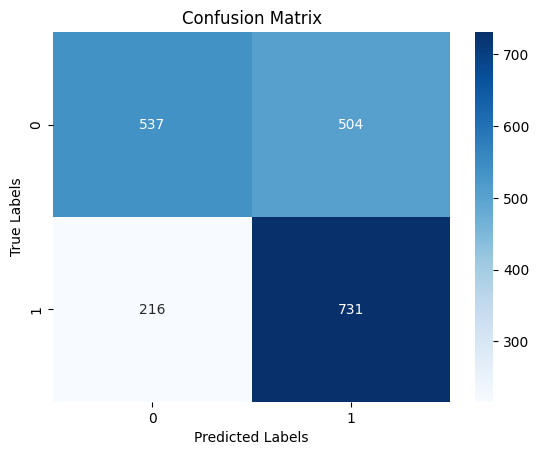

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = confusion_matrix(test_true_labels, test_pred_labels)
# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
# Customize the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Finalmente podemos ver que los resultados en todos los modelos probados no son los mejores. La red nueronal lo hace significativamente mejor que el resto de modelos, sin embargo igual no son buenos resultados.